<a href="https://colab.research.google.com/github/MAliNOZ/CFLTrees/blob/main/CFLT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [4]:
#verisetini indir
import kagglehub

path = kagglehub.dataset_download("dhoogla/ciciotdataset2022")

#verisetini oku
dataset = pd.read_parquet(path)

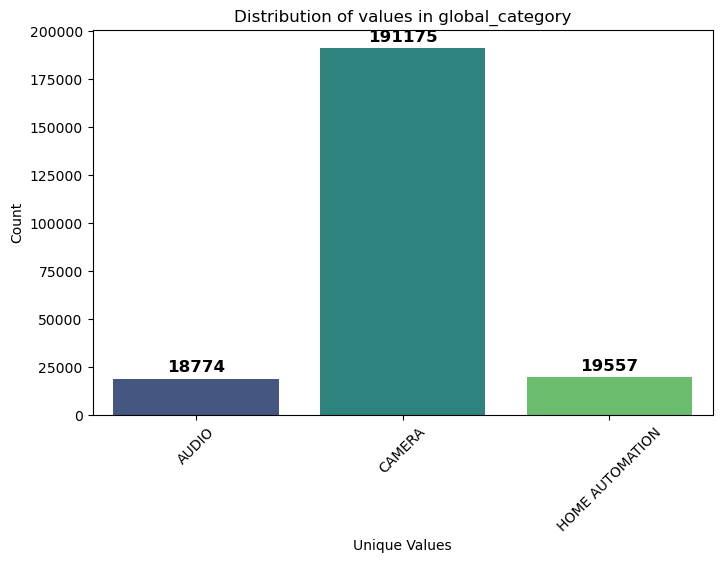

In [5]:
column_name = 'global_category'  # Tahmin edilmek istenen profil
value_counts = dataset[column_name].value_counts()

# Grafik oluştur
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")

# Çubukların üzerine değerleri ekleyelim
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=12, fontweight='bold', padding=3)

# Eksen ve başlık ayarları
plt.xlabel('Unique Values')
plt.ylabel('Count')
plt.title(f'Distribution of values in {column_name}')
plt.xticks(rotation=45)  # Eğer etiketler uzun ise eğimli göster
plt.show()


In [6]:
# Label Encoding (Aygıt tiplerini sayısal değerlere çevir)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(dataset['global_category'])

# Öznitelikleri oluştur
X = dataset.drop(columns=['global_category','device','interaction_type','command'])
X = X.replace({True: 1, False: 0})

#train ve test ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# pip install xgboost

In [8]:
import xgboost as xgb

# Convert to DMatrix (XGBoost's internal format)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set parameters to use GPU
params = {
    'objective': 'multi:softmax',
    'max_depth': 3,
    'eta': 0.1,
    'num_class': len(set(y)),
    'tree_method': 'hist',
    'device' : 'cuda' # This enables GPU support
}

# Train model using GPU
bst = xgb.train(params, dtrain, num_boost_round=100)

print("Model trained successfully on GPU!")

Model trained successfully on GPU!


Accuracy: 0.9996
Precision: 0.9985
Recall: 0.9994
F1-Score: 0.9990


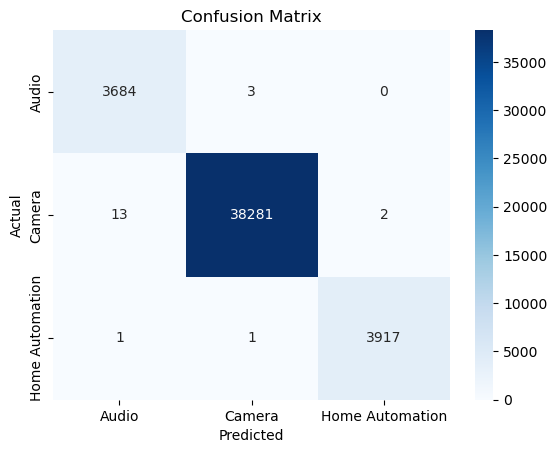

Classification Report:
                 precision    recall  f1-score   support

          Audio       1.00      1.00      1.00      3687
         Camera       1.00      1.00      1.00     38296
Home Automation       1.00      1.00      1.00      3919

       accuracy                           1.00     45902
      macro avg       1.00      1.00      1.00     45902
   weighted avg       1.00      1.00      1.00     45902



In [9]:
target_names = ['Audio', 'Camera', 'Home Automation']

# Predict using the trained model
dtest = xgb.DMatrix(X_test)
y_pred = bst.predict(dtest)  # or use bst.predict() for XGBoost, or bst.predict() for LightGBM

# 1. Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# 2. Precision, Recall, F1-Score (Macro or Weighted)
precision = precision_score(y_test, y_pred, average='macro')  # or 'weighted' for weighted average
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

# 3. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 4. Classification Report (Precision, Recall, F1 per Class)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))


**Federated Learning**

In [11]:
# İstemci sayımız
num_clients = 10

y_t = pd.DataFrame(y_train, columns=["Ground_Truth"])

#indexleri kaldır
X_train.reset_index(drop=True, inplace=True)
y_t.reset_index(drop=True, inplace=True)

all_client_data = pd.concat([X_train, y_t], axis=1)

#verisetini kar
all_client_data = all_client_data.sample(frac=1, random_state=42).reset_index(drop=True)

#verisetini istemci sayısına böl
client_data = np.array_split(all_client_data, num_clients)

#eğitime hazır hale getir
client_X = [client.drop(columns=["Ground_Truth"]) for client in client_data]  # Features for each client
client_y = [client["Ground_Truth"] for client in client_data]  # Target for each client


In [12]:
# Set parameters to use GPU
params = {
    'objective': 'multi:softmax',
    'max_depth': 3,
    'eta': 0.1,
    'num_class': len(set(y)),
    'tree_method': 'hist',
    'device' : 'cuda' # This enables GPU support
}

# Train XGBoost models on each client
def train_xgboost(X_train_client, y_train_client):
    # Convert to DMatrix (XGBoost's internal format)
    dtrain = xgb.DMatrix(X_train_client, label=y_train_client)
    model = xgb.train(params, dtrain, num_boost_round=100)
    return model

trained_models = []

# Train models for each client
for i in range(num_clients):
  model = train_xgboost(client_X[i], client_y[i])
  trained_models.append(model)



In [13]:
#Test verisi DMatrix çevir
dtest = xgb.DMatrix(X_test)

# majority voting ile sonuçların alınması
def aggregate_predictions_majority_voting(models, dtest):
    # Collect predictions from all models and convert to integer
    predictions = np.array([model.predict(dtest).astype(int) for model in models])  # Convert to int

    # majority voting
    aggregated_predictions = np.array([np.bincount(predictions[:, i]).argmax() for i in range(predictions.shape[1])])

    return aggregated_predictions

#majority voting fonksiyonunu çağır
y_pred_aggregated_majority = aggregate_predictions_majority_voting(trained_models, dtest)

print("Aggregated Predictions (Majority Voting):", y_pred_aggregated_majority)


# Ortalama ile sonuçların alınması
def aggregate_predictions_average_probabilities(models, dtest, num_classes):

    # tüm modellerden sonuçları al ve inte çevir
    predictions = np.array([model.predict(dtest).astype(int) for model in models])  # Shape: (num_models, num_samples)

    #etiketleri one-hot encoded olasılıklara çevir
    one_hot_predictions = np.zeros((predictions.shape[0], predictions.shape[1], num_classes))  # Shape: (num_models, num_samples, num_classes)

    for i, pred in enumerate(predictions):
        one_hot_predictions[i, np.arange(predictions.shape[1]), pred] = 1

    # olasılıkların ortalamasını al
    avg_probabilities = np.mean(one_hot_predictions, axis=0)  # Shape: (num_samples, num_classes)

    # en yüksek olasılığa sahip olanı seç
    aggregated_predictions = np.argmax(avg_probabilities, axis=1)

    return aggregated_predictions

# Sınıf sayısını al
num_classes = len(set(y))  # Sınıf sayısına eşit olduğundan emin ol

#ortalama fonksiyonu çağır
y_pred_aggregated_avg_prob = aggregate_predictions_average_probabilities(trained_models, dtest, num_classes)

print("Aggregated Predictions (Average Probabilities):", y_pred_aggregated_avg_prob)


Aggregated Predictions (Majority Voting): [1 1 2 ... 1 1 1]
Aggregated Predictions (Average Probabilities): [1 1 2 ... 1 1 1]


Accuracy (Majority Voting): 99.93%
Confusion Matrix (Majority Voting):
[[ 3674    12     1]
 [    7 38287     2]
 [    0     8  3911]]


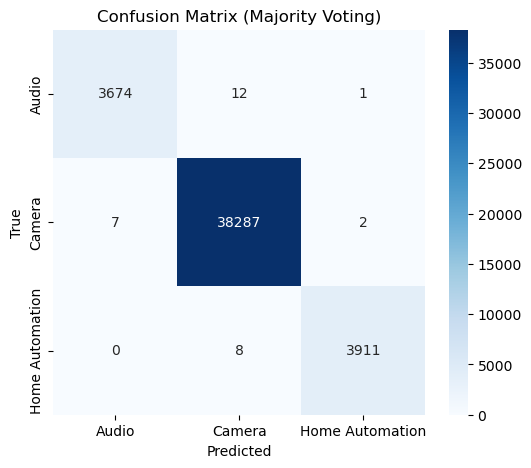

Classification Report (Majority Voting):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3687
           1       1.00      1.00      1.00     38296
           2       1.00      1.00      1.00      3919

    accuracy                           1.00     45902
   macro avg       1.00      1.00      1.00     45902
weighted avg       1.00      1.00      1.00     45902

Accuracy (Average Probabilities): 99.93%
Confusion Matrix (Average Probabilities):
[[ 3674    12     1]
 [    7 38287     2]
 [    0     8  3911]]


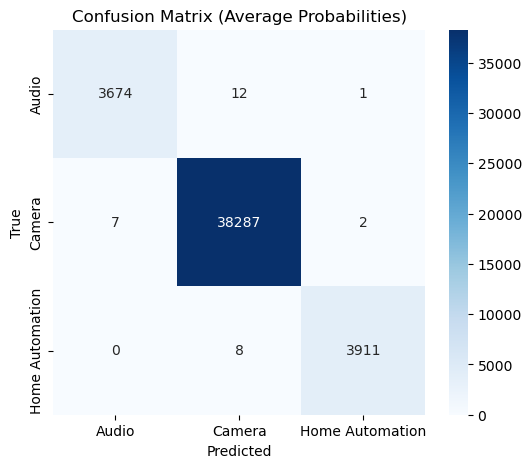

Classification Report (Average Probabilities):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3687
           1       1.00      1.00      1.00     38296
           2       1.00      1.00      1.00      3919

    accuracy                           1.00     45902
   macro avg       1.00      1.00      1.00     45902
weighted avg       1.00      1.00      1.00     45902



In [14]:
# Calculate accuracy for Majority Voting
accuracy_majority = accuracy_score(y_test, y_pred_aggregated_majority)
print(f"Accuracy (Majority Voting): {accuracy_majority * 100:.2f}%")

# Confusion Matrix for Majority Voting
conf_matrix_majority = confusion_matrix(y_test, y_pred_aggregated_majority)
print("Confusion Matrix (Majority Voting):")
print(conf_matrix_majority)

# Plot Confusion Matrix for Majority Voting
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_majority, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix (Majority Voting)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report for Majority Voting
class_report_majority = classification_report(y_test, y_pred_aggregated_majority)
print("Classification Report (Majority Voting):")
print(class_report_majority)

# Calculate accuracy for Average Probabilities
accuracy_avg_prob = accuracy_score(y_test, y_pred_aggregated_avg_prob)
print(f"Accuracy (Average Probabilities): {accuracy_avg_prob * 100:.2f}%")

# Confusion Matrix for Average Probabilities
conf_matrix_avg_prob = confusion_matrix(y_test, y_pred_aggregated_avg_prob)
print("Confusion Matrix (Average Probabilities):")
print(conf_matrix_avg_prob)

# Plot Confusion Matrix for Average Probabilities
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_avg_prob, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix (Average Probabilities)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report for Average Probabilities
class_report_avg_prob = classification_report(y_test, y_pred_aggregated_avg_prob)
print("Classification Report (Average Probabilities):")
print(class_report_avg_prob)


In [31]:
import xgboost
print(xgboost.__version__)

2.0.3
